<a href="https://colab.research.google.com/github/Parthieshwar/Research-Paper/blob/main/Research_Paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installation



In [ ]:
!pip install git+https://github.com/openai/whisper.git

  Cloning https://github.com/openai/whisper.git to /tmp/pip-req-build-w9m5p708
  Running command git clone --filter=blob:none --quiet https://github.com/openai/whisper.git /tmp/pip-req-build-w9m5p708
  Resolved https://github.com/openai/whisper.git to commit 517a43ecd132a2089d85f4ebc044728a71d49f6e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
!pip install --upgrade language_tool_python librosa

## Import libraries

In [ ]:
# Import neccessary library
import whisper
import torch
import language_tool_python
import numpy as np
import matplotlib.pyplot as plt
import warnings
import librosa
import librosa.display
import torchaudio
import torch
from transformers import Wav2Vec2Processor, Wav2Vec2ForSequenceClassification

In [ ]:
# Changing the device to gpu
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# To ignore warnings
warnings.simplefilter("ignore", category=FutureWarning)

## Finding Audio segments and apply to the Emotional Recognition

In [ ]:
file_path = '/content/Output.wav'
y, sr = librosa.load(file_path, sr=22050)

# 1.Extract Pitch
pitch = librosa.yin(y, fmin=50, fmax=300)

# 2.Extract Energy(Stress Indicator)
energy = librosa.feature.rms(y=y)

# 3.Capture Tone & Timbre
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

# 4.Measures frequency of signal changes
zcr = librosa.feature.zero_crossing_rate(y)

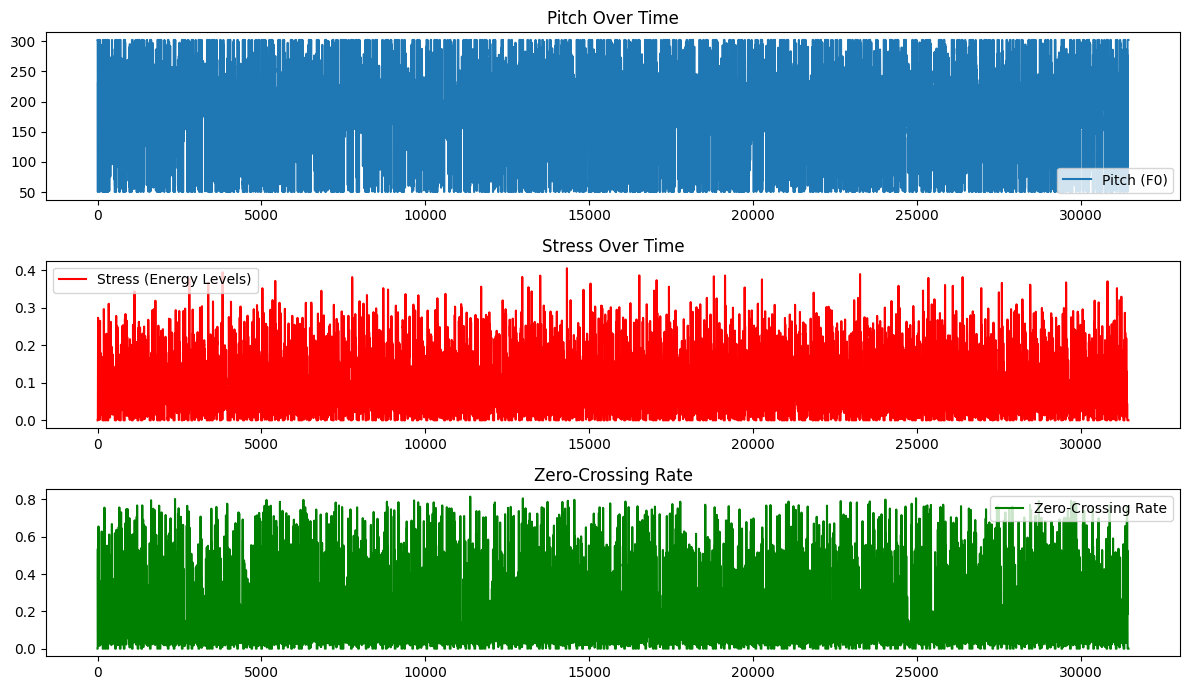

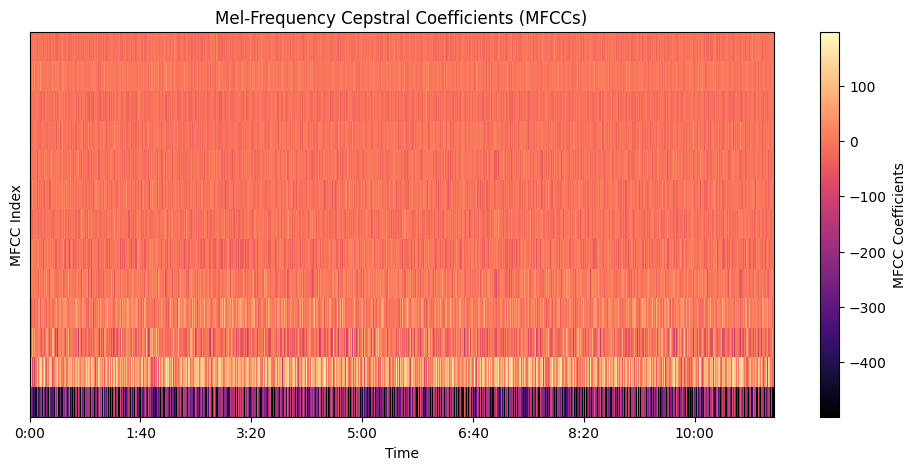

In [ ]:
plt.figure(figsize=(12, 7))

# Pitch Plot
plt.subplot(3, 1, 1)
plt.plot(pitch, label="Pitch (F0)")
plt.legend()
plt.title("Pitch Over Time")

# Energy (Stress) Plot
plt.subplot(3, 1, 2)
plt.plot(energy[0], label="Stress (Energy Levels)", color="red")
plt.legend()
plt.title("Stress Over Time")

# Zero-Crossing Rate Plot
plt.subplot(3, 1, 3)
plt.plot(zcr[0], label="Zero-Crossing Rate", color="green")
plt.legend()
plt.title("Zero-Crossing Rate")

plt.tight_layout()
plt.show()

# MFCCs with Colorbar
plt.figure(figsize=(12, 5))
librosa.display.specshow(mfccs, x_axis="time", sr=sr, cmap="magma")
plt.colorbar(label="MFCC Coefficients")
plt.title("Mel-Frequency Cepstral Coefficients (MFCCs)")
plt.xlabel("Time")
plt.ylabel("MFCC Index")
plt.show()


In [ ]:
# To Calculate the average
avg_pitch=np.nanmean(pitch)
avg_energy=np.mean(energy)
avg_mfccs=np.mean(mfccs, axis=1)
avg_zcr=np.mean(zcr)

audio_features = np.concatenate(([avg_pitch], [avg_energy], avg_mfccs, [avg_zcr]))

print("Average Pitch:", avg_pitch)
print("Average Energy:", avg_energy)
print("Average MFCCs:", avg_mfccs)
print("Average Zero Crossing Rate:", avg_zcr)
print("Audio Features:", audio_features)

Average Pitch: 205.3686172288724
Average Energy: 0.09011204
Average MFCCs: [-276.82883     55.699074    -7.7353263   15.240885     2.0488555
   -6.881708    -5.7859254   -4.769394    -5.7197857   -4.992051
  -10.069522     1.0693909   -7.682075 ]
Average Zero Crossing Rate: 0.14968578003298363
Audio Features: [ 2.05368617e+02  9.01120380e-02 -2.76828827e+02  5.56990738e+01
 -7.73532629e+00  1.52408848e+01  2.04885554e+00 -6.88170815e+00
 -5.78592539e+00 -4.76939392e+00 -5.71978569e+00 -4.99205112e+00
 -1.00695219e+01  1.06939089e+00 -7.68207502e+00  1.49685780e-01]


In [ ]:
MODEL_NAME = "audeering/wav2vec2-large-robust-12-ft-emotion-msp-dim"

processor = Wav2Vec2Processor.from_pretrained(MODEL_NAME)
model = Wav2Vec2ForSequenceClassification.from_pretrained(MODEL_NAME)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

signal, sr = torchaudio.load(file_path)

if sr != 16000:
    signal = torchaudio.transforms.Resample(orig_freq=sr, new_freq=16000)(signal)

if signal.shape[0] > 1:
    signal = torch.mean(signal, dim=0, keepdim=True)

input_values = processor(signal.squeeze().numpy(), sampling_rate=16000, return_tensors="pt").input_values

input_values = input_values.to(device)

with torch.no_grad():
    logits = model(input_values).logits

predicted_class = torch.argmax(logits, dim=-1).item()

emotion_labels = ["neutral", "happy", "sad", "angry", "contempt", "disgust", "fear", "surprise"]

print(f"Predicted Emotion: {emotion_labels[predicted_class]}")

## Convert into text and classifying the domain

In [ ]:
# Convert audio into text
model = whisper.load_model("turbo")
audio = model.transcribe("/content/Output.wav")
print(audio["text"])